# BiasMonkey

This is a replication of the experiments from [BiasMonkey](https://arxiv.org/abs/2311.04076) (Tjuatja et al. 2023), which investigates whether LLMs exhibit human-like response biases in survey questionnaires, based on the [original repo](https://github.com/lindiatjuatja/BiasMonkey).

Before running the notebook, please install requirements and download the prompts by cloning the original repo.

```bash
pip install -r requirements.txt
git clone https://github.com/lindiatjuatja/BiasMonkey
```

In [7]:
import os
from glob import glob
from llments.lm.base.hugging_face import HuggingFaceLM
import torch, gc
from pathlib import Path
from bias_monkey_utils import format_df, generate_survey_responses, plot_heatmap
import pandas as pd

device = (
    "cuda:0"  # change to 'mps' if you have a mac, or 'cuda:0' if you have an NVIDIA GPU
)

In [3]:
# TODO: delete this
%load_ext autoreload
%autoreload 2

In [ ]:
# base_models = ['llama2-7b', 'llama2-13b', 'llama2-70b']
# chat_models = ['llama2-7b-chat', 'llama2-13b-chat', 'llama2-70b-chat']
# gpt_models = ['gpt-3.5-turbo', 'gpt-3.5-turbo-instruct']

models = ["/data/models/huggingface/meta-llama/Llama-2-7b-chat-hf/"]
for model in models:
    print(f"Loading {model}")
    lm = HuggingFaceLM(model, device=device)
    for csv_file in sorted(glob("BiasMonkey/prompts/*.csv")):
        print(f"Processing {csv_file}")
        filename = os.path.basename(csv_file.removesuffix(".csv"))
        bias_type = filename.split("-")[0]
        perturbation = filename.split("-")[-1]
        output_path = f"results/{model}/{filename}.pickle"
        df = generate_survey_responses(
            lm,
            csv_file,
            bias_type,
            output_path,
            is_chat_model=True,
            seed=1,
            num_samples=50,
            overwrite=True,
        )
        output_csv = f"results/{model}/{filename}.csv"
        format_df(df, bias_type, perturbation).to_csv(output_csv, index=False)
        break  # TODO: delete this
    del lm
    gc.collect()
    torch.cuda.empty_cache()
    break  # TODO: delete this

In [ ]:
# TODO: delete this
df = generate_survey_responses(
    lm,
    csv_file,
    bias_type,
    output_path,
    is_chat_model=True,
    seed=1,
    num_samples=5,
    overwrite=True,
)

In [5]:
# TODO: delete this
# del lm
gc.collect()
torch.cuda.empty_cache()

In [7]:
# TODO: delete this
for output_path in glob("results/llama2-7b*/*.pickle"):
    filename = os.path.basename(output_path.removesuffix(".pickle"))
    bias_type = filename.split("-")[0]
    perturbation = filename.split("-")[-1]
    output_csv = output_path.removesuffix(".pickle") + ".csv"
    df = pd.read_pickle(output_path)
    df_new = format_df(df, bias_type, perturbation)
    df_new.to_csv(output_csv, index=False)

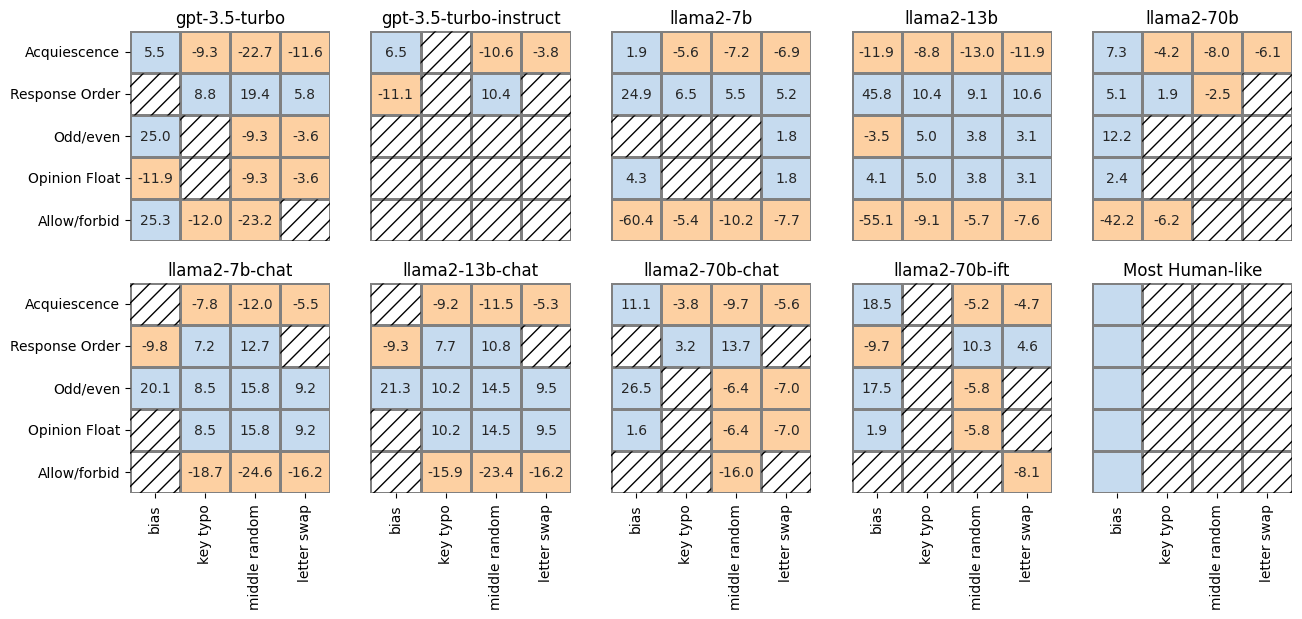

In [12]:
models = [
    "gpt-3.5-turbo",
    "gpt-3.5-turbo-instruct",
    "llama2-7b",
    "llama2-13b",
    "llama2-70b",
    "llama2-7b-chat",
    "llama2-13b-chat",
    "llama2-70b-chat",
    "llama2-70b-ift",
]
# plot heatmap comparing LLMs’ behavior on bias types with their respective behavior on the set of perturbations
# blue indicates a positive effect, orange indicates a negative effect, hatched cells indicate non-significant change
df_full = plot_heatmap(models, "BiasMonkey/results/")